In [111]:
import pandas as pd
import json
import warnings
from typing import Optional, List, Union, Callable
from datetime import datetime, timedelta
warnings.filterwarnings("ignore")
import cufflinks as cf
cf.set_config_file(offline=True, offline_show_link=False, theme='white', sharing='public', colorscale='ggplot')

In [7]:
with open('../input/main-test-daniel-dataset-json/test.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

(Timestamp('2022-01-12 11:10:00+0000', tz='UTC'), 0.09166666666670961, 'CLOSE')

156.884

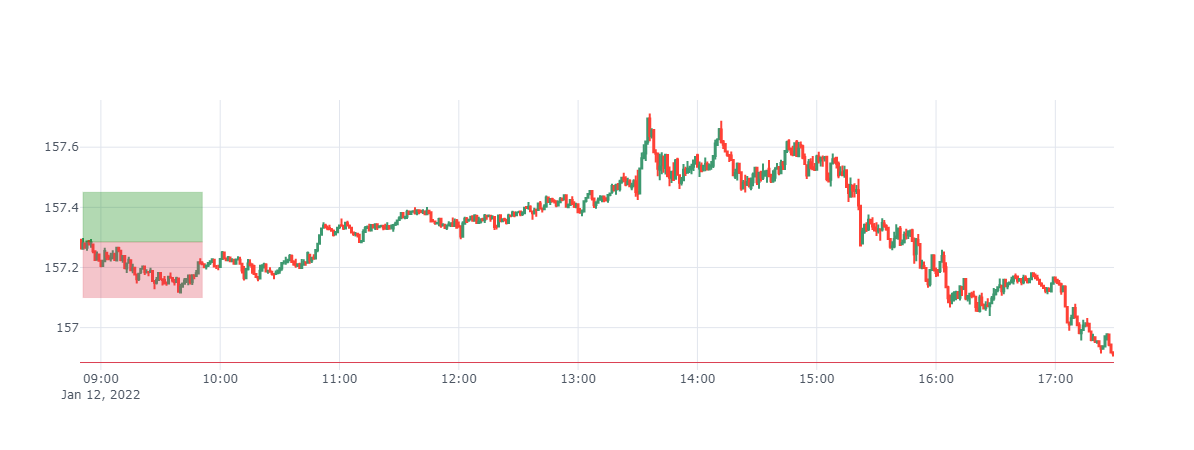

In [155]:
i = 400
display(_determine_position_result(data[i], partials=[1], ignore=[]))
display(find_best_sl(data[i]))
plot_pos(data[i], hline=cf.tools.get_shape(kind='line', yref='close', y=find_best_sl(data[i])))

In [154]:
def plot_pos(p, sl=None, tp=None, hline=None):
    if tp is None:
        tp = get_position_tps(p)[0]
    if sl is None:
        sl = p['sl']['price']
        
    open_ = pd.to_datetime(p['entry']['execution']['time'])
    close_ = open_ + timedelta(hours=1)
    
    sl_shape = cf.tools.get_shape(x0=open_, x1=close_, yref='close', y0=sl, y1=p['entry']['price'], kind='rect', fill=True, opacity=0.3, color='red', width=0.1)
    tp_shape = cf.tools.get_shape(x0=open_, x1=close_, yref='close', y0=tp, y1=p['entry']['price'], kind='rect', fill=True, opacity=0.3, color='green', width=0.1)
    shapes = [s for s in [sl_shape, tp_shape, hline] if s is not None]
    return p['rates'].set_index(pd.to_datetime(p['rates']['time'])).iplot(kind='candle', shapes=shapes, width=0.1)

def _candle_mean(candle: Union[pd.Series, dict]) -> float:
    avg = candle["low"] + (candle["high"] - candle["low"]) / 2
    return round(avg, 6)

def _get_executed_orders(p: dict, ignore: List[str] = None):
    
    if ignore is None:
        ignore = list()
        
    executed = [o for o in p['orders'] if o.get('execution') != dict()]
    sorted_executed = sorted(executed, key=lambda x: pd.to_datetime(x['execution']['time']))
    return [e for e in sorted_executed if e['name'] not in ignore]

def _determine_position_result(p: dict, partials: List[float], ignore: List[str]):
    
    SIDE = 1 if p['side'].upper() == 'BUY' else -1
    
    # get events (orders) in execution order
    events = _get_executed_orders(p, ignore=ignore)
    
    # makes the rates attr back into a df
    p['rates'] = pd.DataFrame(p['rates'])

    if len(events) == 0:
        last_candle = p['rates'].iloc[-1]
        r = SIDE * (_candle_mean(last_candle) - p['entry']['price']) / p['sl_delta']
        return (pd.to_datetime(last_candle).time, r, 'EOP')

    result = 0
    for i, partial in enumerate(partials):

        if i > len(events) - 1:
            break

        if i == 0:
            result_type = events[i]['name']

        close = pd.to_datetime(events[i]['execution']['time'])
        r = SIDE * (events[i]['execution']['price'] - p['entry']['execution']['price']) / p['sl_delta']

        # Closing events
        if events[i]['name'].upper() in ['SL', 'SL_TO_BE']:
            # if it's the first event record the loss,
            # otherwise i'm assuming the second losing 
            # partial is always at breakeven
            if i == 0:
                result = r
            break
        elif events[i]['name'].upper() == ['CLOSE']:
            result = r * (1 - sum(partials[0:i]))
            break

        else: result += r * partial

    return (close, result, result_type)

def base_filter(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(df[df.result>4].index, axis=0)
    df = df.drop(df[df.sl_pips>50].index, axis=0)
    df = df.drop(df[df.sl_pips<5].index, axis=0)
    df = df.drop(results.loc['2021-12-22'].index, axis=0) # outlier
    return df

def get_position_tps(p):
    return sorted(set([o['price'] for o in p['orders'] if o['name'].upper() == 'TP']))

def find_R_extreme(p, from_, to_, type_='max'):
    if not isinstance(p['rates'], pd.DataFrame):
        p['rates'] = pd.DataFrame(p['rates'])
    
    SIDE = 1 if p['side'].upper() == 'BUY' else -1
        
    bound_from = p['rates'][p['rates']['time'] > from_]
    bound_to = bound_from[bound_from['time'] < to_]
    
    high_rel = bound_to.high if SIDE == 1 else bound_to.low
    low_rel = bound_to.low if SIDE == 1 else bound_to.high
    
    bound_to['Rmax'] = SIDE * (high_rel - p['entry']['price']) / p['sl_delta']
    bound_to['Rmin'] = SIDE * (low_rel - p['entry']['price']) / p['sl_delta']
    
    if type_ == 'max':
        return bound_to['Rmax'].max()
    elif type_ == 'min':
        return bound_to['Rmin'].min()
    else: raise TypeError()
        
def find_best_sl(p, for_tp=0):
    '''Tries to find the SL price at which "for_tp" wouldve been hit.
    Returns None if the direction was wrong (tp wouldve never been hit)
    Returns the new SL price expressed as % of the size of the current one'''
    
    if not isinstance(p['rates'], pd.DataFrame):
        p['rates'] = pd.DataFrame(p['rates'])
    
    try:
        tp = get_position_tps(p)[for_tp]
    except AttributeError:
        # if for_tp is not there, pick last tp
        tp = get_position_tps(p)[-1]
    
    SIDE = 1 if p['side'].upper() == 'BUY' else -1
    bound = p['rates']
    
    spread = 20 * p['symbol']['info']['trade_tick_size'] # let's just say 2 pips
    
    if SIDE == 1 and (bound.high >= tp).any():
        new_sl = bound[bound.high <= tp]['low'].min() - spread
        return new_sl
    
    elif SIDE == -1 and (bound.low <= tp).any():
        new_sl = bound[bound.low >= tp]['high'].max() + spread
        return abs(new_sl - p['entry']['price']) / p['sl_delta']
    
    # if there's no tp in rates that hit
    # there's no sl that could've saved the trade
    # the direction was just wrong
    return None

def find_best_tp(p, for_sl):
    '''Tries to find the TP price at which "for_sl" wouldve never been hit.
    Returns None if the trade went straight into loss
    Returns the new TP price expressed in R compared to for_sl'''
    
    if not isinstance(p['rates'], pd.DataFrame):
        p['rates'] = pd.DataFrame(p['rates'])
    
    SIDE = 1 if p['side'].upper() == 'BUY' else -1
    bound = p['rates']
    
    spread = 20 * p['symbol']['info']['trade_tick_size'] # let's just say 2 pips
    
    if SIDE == 1 and (bound.high >= p['entry']['price']).any():
        new_tp = bound[bound.high <= tp]['low'].min() - spread
        return abs(new_sl - p['entry']['price']) / p['sl_delta']
    
    elif SIDE == -1 and (bound.low <= p['entry']['price']).any():
        new_sl = bound[bound.low >= tp]['high'].max() + spread
        return abs(new_sl - p['entry']['price']) / p['sl_delta']
    
    # if there's no tp in rates that hit
    # there's no sl that could've saved the trade
    # the direction was just wrong
    return None

    
def make_results(given: List['Position'],
                 partials: List[float] = None,
                 ignore: List[str] = None,
                 cleanse: Optional[Callable] = None):

    if partials is None:
        partials = [1]

    if ignore is None:
        ignore = list()

    results = list()
    for p in given:
        res = _determine_position_result(p, partials=partials, ignore=ignore)
        open_ = pd.to_datetime(p['time'])
        close_ = pd.to_datetime(res[0])
        min_r_before_win = find_R_extreme(p, from_=open_, to_=close_, type='min')
        max_r_before_loss = find_R_extreme(p, from_=open_, to_=close_, type='max')
        results.append(dict(open=open_,
                            close=close_,
                            symbol=p['symbol']['name'],
                            side=p['side'],
                            sl_pips=p['sl_delta']/p['symbol']['info']['trade_tick_size']/10,
                            result=float(res[1]),
                            type=str(res[2])))

    return pd.DataFrame(results)